<a href="https://colab.research.google.com/github/cccg8105/notebook_AD/blob/master/Analisis/Frecuencia%20inscripciones/NuevasInscripciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis de inscripciones

## Importación de datos

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set()

# carga de archivo
raw_csv_data_CL = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_CL.csv")
raw_csv_data_CO = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_CO.csv")
raw_csv_data_DO = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_DO.csv")
raw_csv_data_EC = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_EC.csv")
raw_csv_data_MX = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_MX.csv")
raw_csv_data_PA = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_PA.csv")
raw_csv_data_PE = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_PE.csv")
raw_csv_data_SV = pd.read_csv("https://raw.githubusercontent.com/cccg8105/notebook_AD/master/Analisis/Frecuencia%20inscripciones/data/data_SV.csv")



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Estructura y formateo de datos

In [3]:
dateColumnName = "Fecha"
analizedValue = "cantidad"

unused_columns = ['cantidad','FuenteIngreso']

df_comp = pd.concat([raw_csv_data_CL, raw_csv_data_CO, raw_csv_data_DO, raw_csv_data_EC, raw_csv_data_MX, raw_csv_data_PA, raw_csv_data_PE, raw_csv_data_SV])

# formateo de fecha 
df_comp[dateColumnName] = pd.to_datetime(df_comp.Fecha, dayfirst = True)
df_comp = df_comp.groupby([dateColumnName,'FuenteIngreso']).sum().reset_index()
df_comp_UB = df_comp[df_comp.FuenteIngreso == "UB"]

df_comp_UB.set_index(dateColumnName, inplace=True, verify_integrity=True)
df_comp_UB=df_comp_UB.asfreq('d')
df_comp_UB=df_comp_UB.fillna(method='ffill')

df_comp_UB['analizedValue'] = df_comp_UB[analizedValue]

df_comp_UB = df_comp_UB.drop(unused_columns, axis=1)
df_comp_UB.head(5)

,analizedValue
Fecha,
2018-01-02,8
2018-01-03,20
2018-01-04,39
2018-01-05,55
2018-01-06,8


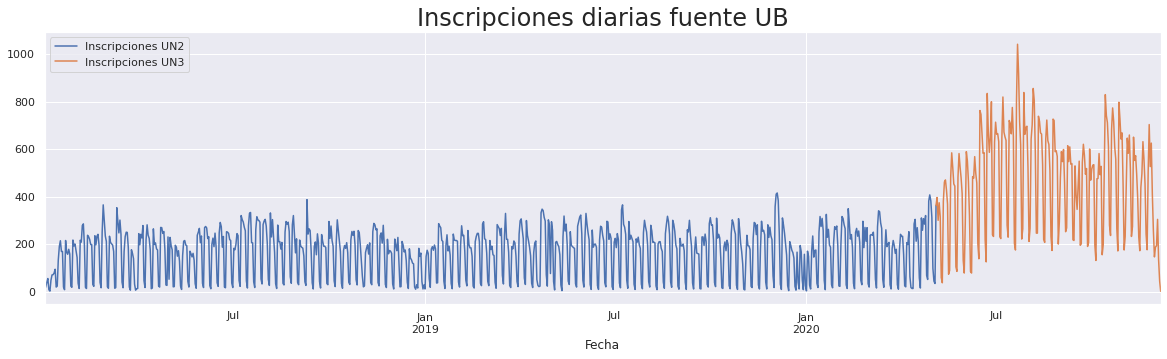

In [4]:
df_comp_UB.analizedValue[:'2020-05-04'].plot(figsize = (20,5), label='Inscripciones UN2')
df_comp_UB.analizedValue['2020-05-04':].plot(figsize = (20,5), label='Inscripciones UN3')
plt.title("Inscripciones diarias fuente UB", size= 24)
plt.legend(loc='upper left')
plt.show()

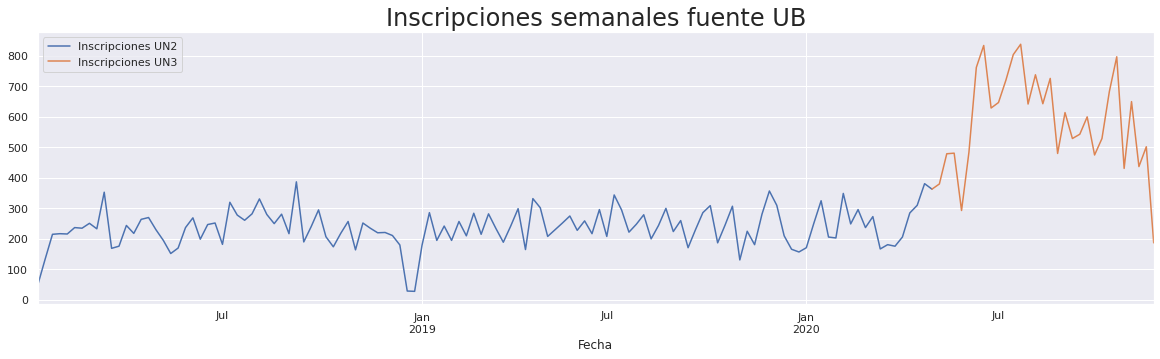

In [5]:
df_comp_UB_w=df_comp_UB.asfreq('W-Mon')

df_comp_UB_w.analizedValue[:'2020-05-04'].plot(figsize = (20,5), label='Inscripciones UN2')
df_comp_UB_w.analizedValue['2020-05-04':].plot(figsize = (20,5), label='Inscripciones UN3')
plt.title("Inscripciones semanales fuente UB", size= 24)
plt.legend(loc='upper left')
plt.show()

## Prueba de estacionalidad

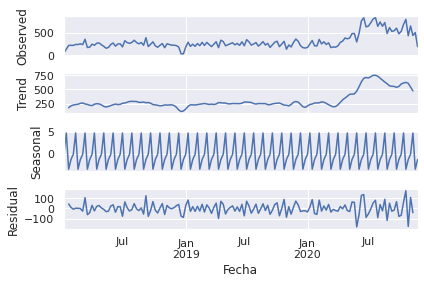

In [6]:
frecuencia = 4

s_dec_additive = seasonal_decompose(df_comp_UB_w.analizedValue, "additive", freq=frecuencia)
s_dec_additive.plot()
plt.show()

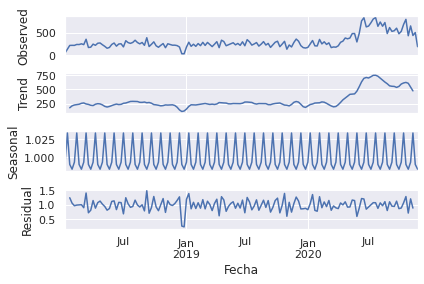

In [7]:
s_dec_multiplicative = seasonal_decompose(df_comp_UB_w.analizedValue, "multiplicative", freq=frecuencia)
s_dec_multiplicative.plot()
plt.show()

## División en entrenamiento y prueba

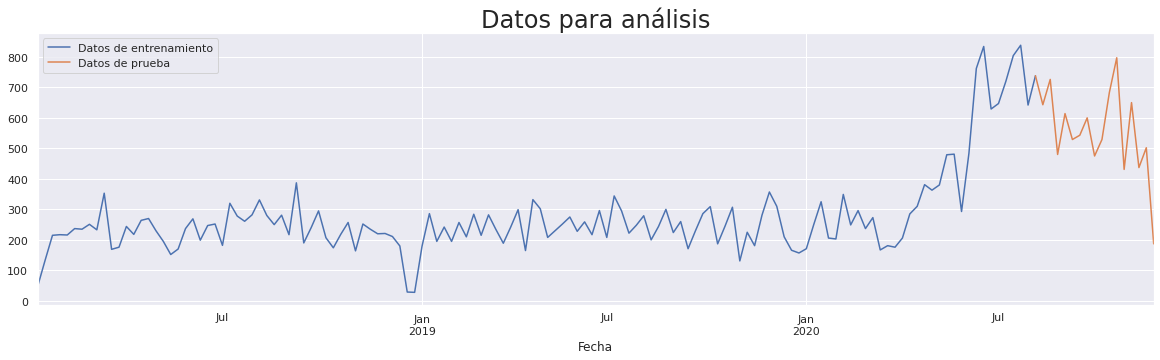

In [63]:
porcentajeEntrenamiento = 0.9
size = int(len(df_comp_UB_w)*porcentajeEntrenamiento)
df_train, df_test = df_comp_UB_w.iloc[:size], df_comp_UB_w.iloc[size-1:]

df_train.analizedValue.plot(figsize = (20,5), label='Datos de entrenamiento')
df_test.analizedValue.plot(figsize = (20,5), label='Datos de prueba')
plt.title("Datos para análisis", size= 24)
plt.legend(loc='upper left')
plt.show()

## Pronóstico con libreria Prophet

### Adecuación de datos

In [64]:
import pandas as pd
from fbprophet import Prophet

dftrain_profet = df_train.reset_index()
dftrain_profet.columns = ['ds','y']
dftrain_profet['ds'] = pd.to_datetime(dftrain_profet['ds'])
dftrain_profet.sample(5)


,ds,y
13,2018-04-09,218
82,2019-08-05,279
75,2019-06-17,217
10,2018-03-19,169
22,2018-06-11,199


### Entrenamiento

In [65]:
additiveModel = Prophet(interval_width=0.95, seasonality_mode='additive')
additiveModel.fit(dftrain_profet)

multiplicativeModel = Prophet(interval_width= 0.95, seasonality_mode='multiplicative')
multiplicativeModel.fit(dftrain_profet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Resultados modelo aditivo

In [82]:
# Generar fechas futuras en base a los datos de prueba
future = additiveModel.make_future_dataframe(periods=len(df_test),freq = 'W-Mon') # 2 años adicionales

forecast = additiveModel.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
148,2020-11-09,611.011733,418.147523,711.978604,601.432244,621.510900,-45.690984,-45.690984,-45.690984,-45.690984,-45.690984,-45.690984,0.0,0.0,0.0,565.320749
149,2020-11-16,618.163086,440.192293,729.977928,607.740907,629.617344,-29.200261,-29.200261,-29.200261,-29.200261,-29.200261,-29.200261,0.0,0.0,0.0,588.962825
150,2020-11-23,625.314440,482.188440,778.404916,613.436412,637.915600,5.709599,5.709599,5.709599,5.709599,5.709599,5.709599,0.0,0.0,0.0,631.024039
151,2020-11-30,632.465793,513.828433,806.042724,619.593221,646.450634,29.752270,29.752270,29.752270,29.752270,29.752270,29.752270,0.0,0.0,0.0,662.218062
152,2020-12-07,639.617146,502.836102,797.823527,624.696874,654.687768,11.289907,11.289907,11.289907,11.289907,11.289907,11.289907,0.0,0.0,0.0,650.907053


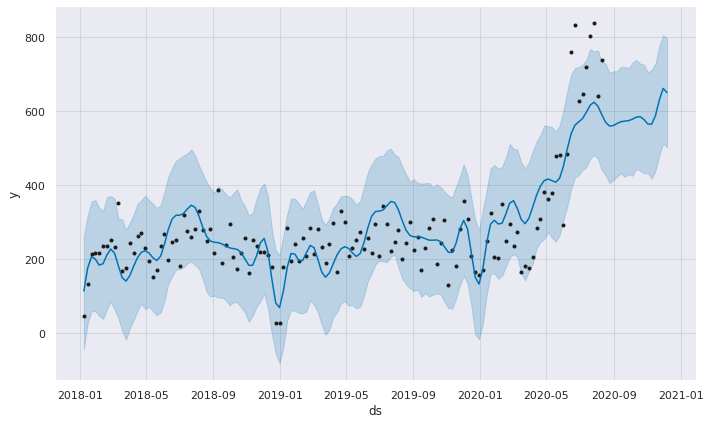

In [83]:
additiveModel.plot(forecast);

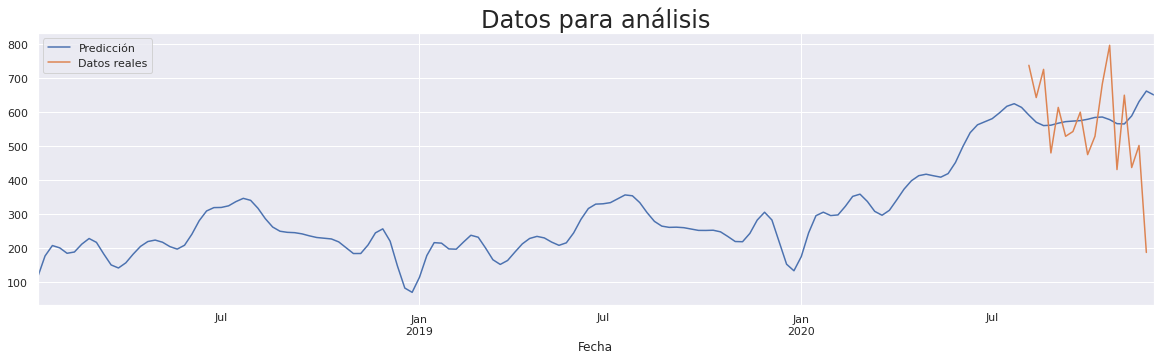

In [85]:
dfrestult = forecast[['ds', 'yhat']]
dfrestult.columns = ['Fecha', 'analizedValue']
dfrestult.set_index('Fecha', inplace=True, verify_integrity=True)

dfrestult.analizedValue.plot(figsize = (20,5), label='Predicción')
df_test.analizedValue.plot(figsize = (20,5), label='Datos reales')
plt.title("Datos para análisis", size= 24)
plt.legend(loc='upper left')
plt.show()

### Resultados modelo multiplicativo

In [86]:
# Generar fechas futuras en base a los datos de prueba
future = multiplicativeModel.make_future_dataframe(periods=len(df_test),freq = 'W-Mon') # 2 años adicionales

forecast = multiplicativeModel.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
148,2020-11-09,578.200828,334.949066,588.111869,569.635421,586.584453,-0.196324,-0.196324,-0.196324,-0.196324,-0.196324,-0.196324,0.0,0.0,0.0,464.686250
149,2020-11-16,584.473033,387.026789,643.714751,575.030446,593.762644,-0.119531,-0.119531,-0.119531,-0.119531,-0.119531,-0.119531,0.0,0.0,0.0,514.610244
150,2020-11-23,590.745237,467.685754,736.285458,580.469261,601.122465,0.018187,0.018187,0.018187,0.018187,0.018187,0.018187,0.0,0.0,0.0,601.489341
151,2020-11-30,597.017441,531.658107,785.461141,585.805474,608.268619,0.108557,0.108557,0.108557,0.108557,0.108557,0.108557,0.0,0.0,0.0,661.827969
152,2020-12-07,603.289645,497.406167,753.611273,591.050975,615.512617,0.040633,0.040633,0.040633,0.040633,0.040633,0.040633,0.0,0.0,0.0,627.803264


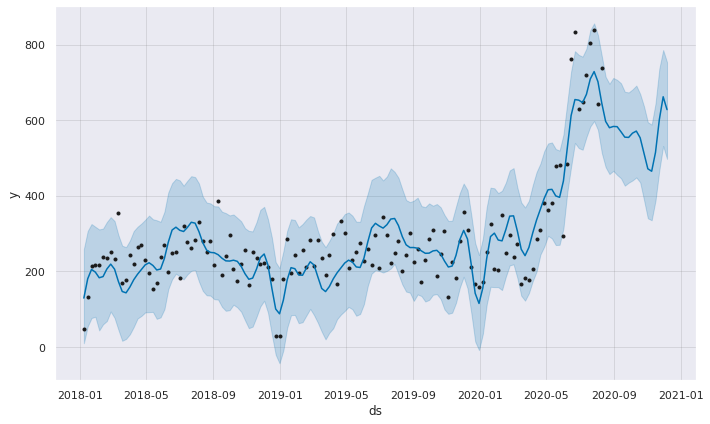

In [87]:
multiplicativeModel.plot(forecast);

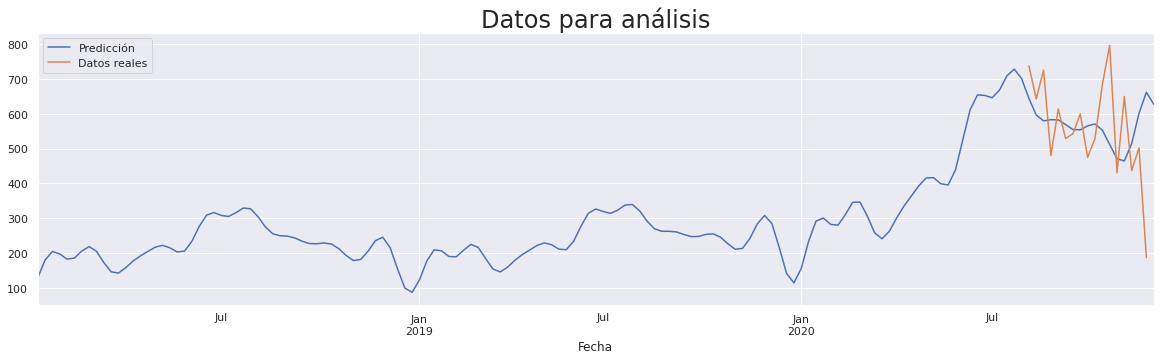

In [88]:
dfrestult = forecast[['ds', 'yhat']]
dfrestult.columns = ['Fecha', 'analizedValue']
dfrestult.set_index('Fecha', inplace=True, verify_integrity=True)

dfrestult.analizedValue.plot(figsize = (20,5), label='Predicción')
df_test.analizedValue.plot(figsize = (20,5), label='Datos reales')
plt.title("Datos para análisis", size= 24)
plt.legend(loc='upper left')
plt.show()